# Validation/Verification & Performance comparison for LOGIC gates with multiple hidden layers and multiple neurons

For Google Colab or Kaggle install crysx_nn

In [ ]:
! pip install --upgrade https://github.com/manassharma07/crysx_nn/tarball/main

## Import stuff

In [72]:
import numpy as np
import cupy as cp
print('numpy',np.__version__)

import matplotlib.pyplot as plt


# Import loss functions
from crysx_nn.loss import MSE_loss_cupy, MSE_loss_grad_cupy
from crysx_nn.loss import BCE_loss, BCE_loss_grad
# Import activation functions
from crysx_nn.activation import Sigmoid, Sigmoid_grad
from crysx_nn.activation import ReLU, ReLU_grad
from crysx_nn.activation import Softmax, Softmax_grad
from crysx_nn.activation import Tanh_offset, Tanh_offset
# Import neural network functions
from crysx_nn.network import back_propagation_cupy, back_propagation_fast_cupy
from crysx_nn.network import nn_optimize, nn_optimize_fast
from crysx_nn.network import nn_optimize_cupy, nn_optimize_fast_cupy
from crysx_nn.network import forward_feed_cupy
from crysx_nn.network import visualize


from tqdm.notebook import tqdm


# import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
print('tf',tf.__version__)

import torch, torchvision
print('torch',torch.__version__)
rng = np.random.default_rng()
import time
from timeit import default_timer as timer

numpy 1.19.2
tf 2.2.3
torch 1.10.1


## Ensure that evertyhing is only using CPU

In [73]:
torch.cuda.is_available()

False

In [74]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [75]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [76]:
print(tf.test.is_built_with_cuda())

True


## Check if NumPy is linked with MKL or not

In [77]:
np.show_config()

blas_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
blas_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
lapack_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
lapack_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = [

## Start with the common stuff

In [78]:
nInputs = 2 # No. of features
nOutputs = 1
neurons_per_layer = [10,10,10,1] # Hidden layers and output layer
activation_func_names = ['Sigmoid','Sigmoid','Sigmoid','Sigmoid',]
nLayers = len(neurons_per_layer)
eeta = 0.5
nEpochs=10**4
batchSize = 4

#### Activation function dictionary for all the frameworks

In [79]:


act_func_dict_PyTorch = {'Sigmoid':torch.nn.Sigmoid(),'ReLU':torch.nn.ReLU(),'ELU':torch.nn.ELU(), 'Hardshrink' : torch.nn.Hardshrink(),'Hardsigmoid':torch.nn.Hardsigmoid(),\
                 'Hardtanh':torch.nn.Hardtanh(),'Hardswish':torch.nn.Hardswish(),'LeakyReLU':torch.nn.LeakyReLU(),'LogSigmoid':torch.nn.LogSigmoid(),\
                 'Tanh':torch.nn.Tanh(),'Softmax':torch.nn.Softmax(dim=1),'Softmin':torch.nn.Softmin(dim=1),'LogSoftmax':torch.nn.LogSoftmax()}
act_func_dict_tensorflow = {'Sigmoid':'sigmoid','Softmax':'softmax','ReLU':'relu','LeakyReLU':'leakyrelu'}



## Visualize 

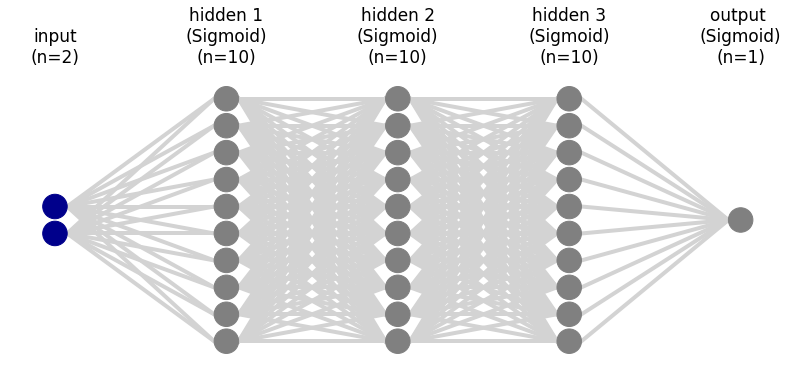

In [80]:
visualize(nInputs, neurons_per_layer, activation_func_names)

## Set inputs

In [81]:
inputs = np.array([[0.,0.,1.,1.],[0.,1.,0.,1.]]).T.astype('float32')
print(inputs)
print(inputs.dtype)


[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
float32


In [82]:
# AND function
outputAND = np.array([0.,0.,0.,1.])
outputAND = np.asarray([outputAND]).T
# OR function
outputOR = np.array([0.,1.,1.,1.])
outputOR = np.asarray([outputOR]).T
# NAND function
outputNAND = np.array([1.,1.,1.,0.])
outputNAND = np.asarray([outputNAND]).T
# XOR function
outputXOR = np.array([0.,1.,1.,0.])
outputXOR = np.asarray([outputXOR]).T

## Set outputs

In [83]:
# outputs = outputAND
# outputs = outputOR
# outputs = outputNAND
outputs = outputXOR
outputs = outputs.astype('float32')
print(outputs)
print(outputs.dtype)

[[0.]
 [1.]
 [1.]
 [0.]]
float32


# Keras implementation

In the following we have to be careful and change the network nodes, and layers manually. 

TODO: Make the neural network be generated in a loop automatically using the parameters already defined.

In [84]:
# # define the keras model
# model = Sequential()
# model.add(Dense(100, input_dim=2, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(1, activation='sigmoid', use_bias=True))

# model.summary()

## Make the neural network programatically

In [85]:
# define the keras model
model = Sequential()
# First Hidden layer
model.add(Dense(neurons_per_layer[0], input_dim=nInputs, activation=act_func_dict_tensorflow[activation_func_names[0]], use_bias=True))

if nLayers>1:
    # Hidden layers
    for i in range(nLayers-2):
        model.add(Dense(neurons_per_layer[i], activation=act_func_dict_tensorflow[activation_func_names[i]], use_bias=True))
    # Output layer
    model.add(Dense(neurons_per_layer[nLayers-1], activation=act_func_dict_tensorflow[activation_func_names[nLayers-1]], use_bias=True))
    
model.summary()
    

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_13 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_14 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________


## Check the initial weights and biases for each layer

Note how the weights matrix is not 4x2 but rather 2x4

In [86]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[-0.4442455  -0.21104208 -0.06213236  0.40682548  0.64465016  0.5566928
  -0.66511315  0.43177956 -0.43966275 -0.1685744 ]
 [-0.17054433 -0.03539675  0.06060094 -0.11957312 -0.09256226 -0.2228024
  -0.07944024 -0.27919623 -0.5661417  -0.0456093 ]]

 Biases for layer  1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

 Weights for layer  2
[[ 0.29458094  0.36532432 -0.527139    0.08218676  0.41727608 -0.33139437
   0.1012277  -0.33493328  0.09144151  0.29515886]
 [ 0.46320772  0.03458053 -0.4331123   0.13872725 -0.40467536  0.06883281
  -0.01038182 -0.40344366 -0.46582493  0.17902035]
 [-0.28298268  0.27164012 -0.26254526  0.16333658  0.3885576  -0.26623827
   0.3439489   0.46674168 -0.48422036 -0.44823965]
 [ 0.13631934 -0.39467263 -0.42822036  0.24409342 -0.20474133  0.27547157
  -0.35628587 -0.3038851   0.26995504  0.38348186]
 [-0.2819965   0.27679086  0.24076813  0.40505564 -0.2846918  -0.18378353
   0.06682813 -0.0345428   0.0138877   0.00640845]
 [-0.3539533  -0.12017956 

## Save the weights generated by tf.keras and use them for our implementation as well

In [87]:
weightsOriginal = []
biasesOriginal = []


for i in range(nLayers):
    weightsOriginal.append(model.layers[i].get_weights()[0].T)
    biasesOriginal.append(model.layers[i].get_weights()[1].T)

print('Weights matrices: ',weightsOriginal)
print('Biases: ',biasesOriginal)

Weights matrices:  [array([[-0.4442455 , -0.17054433],
       [-0.21104208, -0.03539675],
       [-0.06213236,  0.06060094],
       [ 0.40682548, -0.11957312],
       [ 0.64465016, -0.09256226],
       [ 0.5566928 , -0.2228024 ],
       [-0.66511315, -0.07944024],
       [ 0.43177956, -0.27919623],
       [-0.43966275, -0.5661417 ],
       [-0.1685744 , -0.0456093 ]], dtype=float32), array([[ 0.29458094,  0.46320772, -0.28298268,  0.13631934, -0.2819965 ,
        -0.3539533 , -0.05608904,  0.4408291 ,  0.41618663, -0.35251254],
       [ 0.36532432,  0.03458053,  0.27164012, -0.39467263,  0.27679086,
        -0.12017956,  0.4215415 ,  0.28009564, -0.17424151, -0.17985246],
       [-0.527139  , -0.4331123 , -0.26254526, -0.42822036,  0.24076813,
         0.03142232,  0.015733  , -0.4127336 , -0.24682909, -0.5181341 ],
       [ 0.08218676,  0.13872725,  0.16333658,  0.24409342,  0.40505564,
         0.0160895 , -0.10580581,  0.1816594 ,  0.5006908 ,  0.28287846],
       [ 0.41727608, -0.4

## Compile model

In [88]:
# compile the keras model

# In the following manner we can't set the learning rate of the optimizer
# model.compile(loss='mse', optimizer='sgd', metrics=['mse'])

# So use the following instead
model.compile(loss='mse', optimizer=optimizers.SGD(learning_rate=eeta), metrics=['mse'])



## Forward feed

Note: Batch size=4 indicates that we are using all the training data(examples) and therefore this is the equivalent of my own implementation as I don't have stochastic/minibatch gradient descent implementation yet.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [39]:
model.evaluate(inputs, outputs, batch_size=batchSize)

1/1 [==============================] - 0s 999us/step - loss: 0.3070 - mse: 0.3070


[0.3069898784160614, 0.3069898784160614]

## Does tf.model.evaluate change the weights and biases?

In [40]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[ 0.23630303  0.5126218   0.3729126  -0.12847453 -0.26293194 -0.613007
  -0.45503575 -0.43469113 -0.702624    0.18347198]
 [-0.34206128 -0.02099484 -0.39437985  0.00166428  0.66723365 -0.41688037
  -0.5589402  -0.15970081  0.6229196  -0.12845027]]

 Biases for layer  1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

 Weights for layer  2
[[ 0.4009292   0.3651445   0.53958726  0.5047784   0.14405847  0.16567838
   0.27240396  0.08706236  0.08342123  0.35629475]
 [ 0.20269048 -0.37326324 -0.01105332  0.13542968 -0.06854042 -0.16429755
  -0.06715056 -0.35341504 -0.2186054   0.5405251 ]
 [ 0.3119486   0.37249672 -0.54109854 -0.27842975 -0.31507957 -0.32988244
  -0.2593793   0.24381852 -0.34168464 -0.42893493]
 [ 0.20382905 -0.2902958   0.11477166 -0.0276286  -0.4456377  -0.06271282
   0.13757408 -0.28431845 -0.50184846  0.36049968]
 [-0.29542595  0.45182896  0.08490521  0.48431218  0.39469236 -0.11834037
  -0.3187279  -0.15771568 -0.1772471   0.42945534]
 [-0.10404891 -0.09529069 

From the above, we can be sure that it does not change the weights and biases

## Fit 1 epoch  (forward feed, backpropagation, updating the weights, biases)

Let us just try to see and compare the error after just 1 epoch. 

We should expect the model to perform forward feed, calculate loss/error,
perform backpropagation,
and adjust the weights and biases based on the learning rate.

Note: Batch size=32 indicates that we are using all the training data(examples) in batches.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [41]:
# fit the keras model on the dataset
model.fit(inputs, outputs, epochs=1, batch_size=batchSize)

1/1 [==============================] - 0s 1ms/step - loss: 0.3070 - mse: 0.3070


## Now the weights and biases must have been updated

In [42]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[ 0.23633897  0.5125068   0.37270793 -0.12862392 -0.26289532 -0.61308414
  -0.45515433 -0.43462527 -0.7023505   0.18355633]
 [-0.34202155 -0.0211033  -0.39458776  0.00151616  0.66727597 -0.4169547
  -0.5590588  -0.15963693  0.6231909  -0.12836498]]

 Biases for layer  1
[ 7.6369950e-05 -2.3433442e-04 -4.1514877e-04 -3.0037350e-04
  8.3363120e-05 -1.9167925e-04 -2.9622414e-04  1.4115908e-04
  5.4919237e-04  1.7183306e-04]

 Weights for layer  2
[[ 0.4004074   0.36495933  0.5398769   0.5051842   0.14481945  0.1662851
   0.27270713  0.08695243  0.08346847  0.35566303]
 [ 0.20208962 -0.37347582 -0.01072086  0.13589652 -0.06766532 -0.16359872
  -0.06680055 -0.353541   -0.21855114  0.539799  ]
 [ 0.3114154   0.37230757 -0.54080284 -0.27801546 -0.31430218 -0.32926232
  -0.25906932  0.24370629 -0.34163645 -0.42958063]
 [ 0.20330982 -0.2904799   0.11506028 -0.02722362 -0.44488046 -0.06210973
   0.1378755  -0.28442788 -0.50180125  0.35987252]
 [-0.29601693  0.45162013  0.

## Now let us do a forward feed again and calculate the loss/error

In [43]:
out = model.evaluate(inputs, outputs, batch_size=batchSize)
print(out)

1/1 [==============================] - 0s 998us/step - loss: 0.2908 - mse: 0.2908
[0.2908006012439728, 0.2908006012439728]


### The above result, compares well with the result from my own implementation (when biases are updated independently)

## Now let us let the model train for 10^4 epochs



In [50]:
%%time
# fit the keras model on the dataset
# history = model.fit(tf.convert_to_tensor(inputs, dtype=tf.float32), tf.convert_to_tensor(outputs, dtype=tf.float32), epochs=nEpochs, batch_size=nSamples, verbose=0)
history = model.fit(inputs, outputs, epochs=nEpochs, batch_size=batchSize, verbose=0)

Wall time: 7.25 s


Turns out that this was quite slow. At first, I thought that the problem was that it was printing at each epoch. So I set the verbose=0 (silent). But still, it was incredibly slow compared to my implementation as well as PyTorch, even though we used own for loop in both the cases.

In [45]:
history.history

{'loss': [0.2908006012439728,
  0.27761709690093994,
  0.2678114175796509,
  0.2610684335231781,
  0.25670433044433594,
  0.2539975643157959,
  0.25236472487449646,
  0.2513964772224426,
  0.25082820653915405,
  0.25049659609794617,
  0.25030380487442017,
  0.250191867351532,
  0.2501269578933716,
  0.2500893771648407,
  0.2500675618648529,
  0.25005489587783813,
  0.25004756450653076,
  0.2500433027744293,
  0.25004079937934875,
  0.25003933906555176,
  0.2500384747982025,
  0.2500379681587219,
  0.25003764033317566,
  0.25003743171691895,
  0.2500373125076294,
  0.25003719329833984,
  0.25003713369369507,
  0.2500370740890503,
  0.2500370144844055,
  0.25003695487976074,
  0.25003692507743835,
  0.25003689527511597,
  0.2500368356704712,
  0.2500367760658264,
  0.2500367760658264,
  0.25003668665885925,
  0.25003665685653687,
  0.2500365972518921,
  0.2500365674495697,
  0.2500365376472473,
  0.2500365078449249,
  0.25003641843795776,
  0.2500363886356354,
  0.2500363290309906,
  0.2

## Now also let us have a look at the predictions for the sake of the tutorial

In [20]:
# make probability predictions with the model
predictions = model.predict(inputs)
print(predictions)

[[0.02935426]
 [0.96719855]
 [0.97303754]
 [0.03104703]]


## We have seen how to initialize custom weights/biases, perform forward feed, train/optimize the model, and finally how to check the updated parameters.


## Let us now see how we can see the input/output at each layer for debugging purposes.

In [21]:

for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    print(model.layers[i].input)
    print('\n Outputs for layer ',i+1)
    print(model.layers[i].output)


 Inputs for layer  1
Tensor("dense_input:0", shape=(None, 2), dtype=float32)

 Outputs for layer  1
Tensor("dense/Identity:0", shape=(None, 10), dtype=float32)

 Inputs for layer  2
Tensor("dense/Identity:0", shape=(None, 10), dtype=float32)

 Outputs for layer  2
Tensor("dense_1/Identity:0", shape=(None, 10), dtype=float32)

 Inputs for layer  3
Tensor("dense_1/Identity:0", shape=(None, 10), dtype=float32)

 Outputs for layer  3
Tensor("dense_2/Identity:0", shape=(None, 10), dtype=float32)

 Inputs for layer  4
Tensor("dense_2/Identity:0", shape=(None, 10), dtype=float32)

 Outputs for layer  4
Tensor("dense_3/Identity:0", shape=(None, 1), dtype=float32)


In [22]:

for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    print(model.layers[i].input)
    print('\n Outputs for layer ',i+1)
    print(model.layers[i].output)


 Inputs for layer  1
Tensor("dense_input:0", shape=(None, 2), dtype=float32)

 Outputs for layer  1
Tensor("dense/Identity:0", shape=(None, 10), dtype=float32)

 Inputs for layer  2
Tensor("dense/Identity:0", shape=(None, 10), dtype=float32)

 Outputs for layer  2
Tensor("dense_1/Identity:0", shape=(None, 10), dtype=float32)

 Inputs for layer  3
Tensor("dense_1/Identity:0", shape=(None, 10), dtype=float32)

 Outputs for layer  3
Tensor("dense_2/Identity:0", shape=(None, 10), dtype=float32)

 Inputs for layer  4
Tensor("dense_2/Identity:0", shape=(None, 10), dtype=float32)

 Outputs for layer  4
Tensor("dense_3/Identity:0", shape=(None, 1), dtype=float32)


## We can't really see any numbers in the above output
## So we need to do something more

In [23]:
for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    func = K.function([model.get_layer(index=0).input], model.get_layer(index=i).input)
    layerInput = func([inputs])  # input_data is a numpy array
    print(layerInput)
    print('\n Outputs for layer ',i+1)
    func = K.function([model.get_layer(index=0).input], model.get_layer(index=i).output)
    layerOutput = func([inputs])  # input_data is a numpy array
    print(layerOutput)





 Inputs for layer  1
[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]

 Outputs for layer  1
[[0.6761799  0.879526   0.4434364  0.6602717  0.48514444 0.49641475
  0.2941286  0.49906188 0.3922131  0.5469405 ]
 [0.949973   0.99801123 0.64454424 0.29353926 0.40139186 0.90612805
  0.71680456 0.49170354 0.6802401  0.4353363 ]
 [0.29444355 0.16177657 0.1683524  0.9476763  0.39991242 0.8766435
  0.03518328 0.38843045 0.2123518  0.4647691 ]
 [0.79145193 0.9299048  0.31540293 0.79475045 0.32168055 0.98583364
  0.18134132 0.38146114 0.47055587 0.35672992]]

 Inputs for layer  2
[[0.6761799  0.879526   0.4434364  0.6602717  0.48514444 0.49641475
  0.2941286  0.49906188 0.3922131  0.5469405 ]
 [0.949973   0.99801123 0.64454424 0.29353926 0.40139186 0.90612805
  0.71680456 0.49170354 0.6802401  0.4353363 ]
 [0.29444355 0.16177657 0.1683524  0.9476763  0.39991242 0.8766435
  0.03518328 0.38843045 0.2123518  0.4647691 ]
 [0.79145193 0.9299048  0.31540293 0.79475045 0.32168055 0.98583364
  0.18134132 0.38146114 

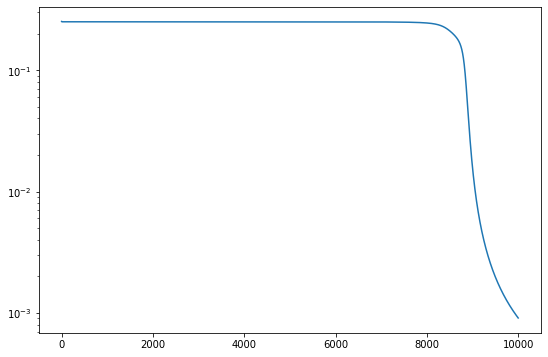

In [24]:
# Plot the error vs epochs
plt.plot(history.history['loss'])
plt.yscale('log')
plt.show()

# My implementation

### Get the cupy versions of input, output, weights and biases arrays 

In [89]:
inputs_cupy = cp.asarray(inputs)
outputs_cupy = cp.asarray(outputs)
weightsOriginal_cupy = []
biasesOriginal_cupy = []
for i in range(nLayers):
    weightsOriginal_cupy.append(cp.asarray(weightsOriginal[i]))
    biasesOriginal_cupy.append(cp.asarray(biasesOriginal[i]))

## Forwad feed once

In [33]:
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, weightsOriginal, biasesOriginal, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)

# Error
print('Error:\n', MSE_loss(a[nLayers],outputs)/batchSize)

Outputs at each layer (including input layer):
  [array([[0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 1.]], dtype=float32), array([[0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.49003932, 0.48817104, 0.50629395, ..., 0.486346  , 0.5068818 ,
        0.51280135],
       [0.5100677 , 0.50139165, 0.49643084, ..., 0.49373865, 0.49735844,
        0.50800294],
       [0.50010705, 0.48956198, 0.502725  , ..., 0.48009145, 0.5042405 ,
        0.52079576]], dtype=float32), array([[0.46120936, 0.36138815, 0.30492193, ..., 0.62413985, 0.59955317,
        0.4224788 ],
       [0.4615413 , 0.35907194, 0.30458722, ..., 0.62566704, 0.59944385,
        0.4230656 ],
       [0.46419272, 0.36222392, 0.3051756 , ..., 0.6265128 , 0.60206956,
        0.42540574],
       [0.46452528, 0.35990503, 0.3048399 , ..., 0.6280362 , 0.6019605 ,
        0.42599288]], dtype=float32), array([[0.2660938 , 0.47074488, 0.41315237, ..., 0.36766136, 0.35755593,
      

## Backpropagation

In [34]:
# Get the derivative of the output cost function wrt to the output vector of the output layer
# The input arguments should always be an array
dc_daL = MSE_loss_grad(a[nLayers], outputs)/batchSize
print('Gradient of the error function wrt to the predicted output of the output layer\n',dc_daL)

# Perform Back Propagation and get the derivatives wrt the weights and biases
derWeights, derBiases, weights, biases = back_propagation(z, a, activation_func_names, nLayers, batchSize, weightsOriginal, biasesOriginal, eeta, dc_daL)
print('Gradient of Cost (error function) wrt weights:\n',derWeights)
print('Gradient of Cost (error function) wrt biases:\n',derBiases)

Gradient of the error function wrt to the predicted output of the output layer
 [[ 0.20877738]
 [-0.29126984]
 [-0.29110923]
 [ 0.20884338]]
Gradient of Cost (error function) wrt weights:
 [array([[-6.7160981e-06, -6.7713172e-06],
       [-1.9493937e-06, -1.9685804e-06],
       [-1.2742665e-05, -1.2726250e-05],
       ...,
       [-7.6289439e-07, -7.9831716e-07],
       [-4.5078459e-06, -4.4236522e-06],
       [-2.6377788e-06, -2.7000710e-06]], dtype=float32), array([[ 2.26507400e-05,  2.24121595e-05,  2.27100572e-05, ...,
         2.21972368e-05,  2.27443470e-05,  2.31197191e-05],
       [-3.42741941e-06, -3.39126609e-06, -3.43558486e-06, ...,
        -3.35870482e-06, -3.44076398e-06, -3.49749234e-06],
       [-3.15673096e-05, -3.12345001e-05, -3.16483347e-05, ...,
        -3.09347161e-05, -3.16961414e-05, -3.22194428e-05],
       ...,
       [-1.26286341e-05, -1.24941944e-05, -1.26599225e-05, ...,
        -1.23731097e-05, -1.26792038e-05, -1.28903139e-05],
       [-3.85124258e-05, -3

## Gradient descent (update the weights and biases)

In [35]:
newWeights = [weightsOriginal[i] - eeta*derWeights[i] for i in range(nLayers)]
print('New Weights: ', newWeights)

newBiases = [biasesOriginal[i] - eeta*derBiases[i] for i in range(nLayers)]
# newBiases = biasesOriginal
print('New Biases: ', newBiases)

New Weights:  [array([[ 0.04027955, -0.03984465],
       [ 0.00556753, -0.04732367],
       [-0.01427054,  0.02518347],
       ...,
       [-0.0250464 , -0.05462918],
       [-0.01056414,  0.027531  ],
       [ 0.03201582,  0.05121794]], dtype=float32), array([[ 0.03018852, -0.00487641,  0.00298921, ..., -0.00576888,
         0.00109794, -0.02996279],
       [-0.02509252, -0.00930041,  0.03436106, ...,  0.00702566,
        -0.0210026 ,  0.03212038],
       [ 0.03598116, -0.03663293,  0.03604322, ..., -0.03208125,
        -0.03818724, -0.02089714],
       ...,
       [ 0.03194422, -0.03543187, -0.03110309, ..., -0.02737474,
        -0.02371899, -0.03059182],
       [ 0.02860489,  0.03229774,  0.0281264 , ...,  0.03349115,
        -0.01706082, -0.01940624],
       [-0.02177706,  0.03210373, -0.00254965, ...,  0.00418863,
        -0.00810771,  0.02265545]], dtype=float32), array([[ 3.67073230e-02,  1.28417108e-02,  2.35879538e-03, ...,
        -7.05265207e-03, -3.29059549e-02,  2.70009618

## Forward feed again and check the loss/error

In [36]:
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, weightsOriginal, biasesOriginal, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)

# New Error
print('New Error:\n', MSE_loss(a[nLayers],outputs)/batchSize)

Outputs at each layer (including input layer):
  [array([[0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 1.]], dtype=float32), array([[0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.49003932, 0.48817104, 0.50629395, ..., 0.486346  , 0.5068818 ,
        0.51280135],
       [0.5100677 , 0.50139165, 0.49643084, ..., 0.49373865, 0.49735844,
        0.50800294],
       [0.50010705, 0.48956198, 0.502725  , ..., 0.48009145, 0.5042405 ,
        0.52079576]], dtype=float32), array([[0.46120936, 0.36138815, 0.30492193, ..., 0.62413985, 0.59955317,
        0.4224788 ],
       [0.4615413 , 0.35907194, 0.30458722, ..., 0.62566704, 0.59944385,
        0.4230656 ],
       [0.46419272, 0.36222392, 0.3051756 , ..., 0.6265128 , 0.60206956,
        0.42540574],
       [0.46452528, 0.35990503, 0.3048399 , ..., 0.6280362 , 0.6019605 ,
        0.42599288]], dtype=float32), array([[0.2660938 , 0.47074488, 0.41315237, ..., 0.36766136, 0.35755593,
      

## ** With np.einsum (slightly Slower than opt_einsum expression reuse)**

In [90]:
%%time

# Run optimization
optWeights, optBiases, errorPlot = nn_optimize_cupy(inputs_cupy, outputs_cupy, activation_func_names, nLayers, nEpochs=nEpochs, batchSize=batchSize, eeta=eeta, weights=weightsOriginal_cupy, biases=biasesOriginal_cupy, errorFunc=MSE_loss_cupy, gradErrorFunc=MSE_loss_grad_cupy,miniterEpoch=100,batchProgressBar=False,miniterBatch=100)



  0%|          | 0/10000 [00:00<?, ?it/s]

Average Error with initial weights and biases: 0.25006646
Wall time: 29.9 s


In [91]:
print(errorPlot)

[array(0.25006646, dtype=float32), array(0.2500301, dtype=float32), array(0.25001174, dtype=float32), array(0.25000247, dtype=float32), array(0.24999781, dtype=float32), array(0.24999544, dtype=float32), array(0.24999423, dtype=float32), array(0.24999365, dtype=float32), array(0.24999332, dtype=float32), array(0.24999316, dtype=float32), array(0.2499931, dtype=float32), array(0.24999306, dtype=float32), array(0.24999303, dtype=float32), array(0.249993, dtype=float32), array(0.24999297, dtype=float32), array(0.249993, dtype=float32), array(0.249993, dtype=float32), array(0.24999295, dtype=float32), array(0.24999295, dtype=float32), array(0.24999297, dtype=float32), array(0.24999294, dtype=float32), array(0.24999295, dtype=float32), array(0.24999295, dtype=float32), array(0.2499929, dtype=float32), array(0.24999292, dtype=float32), array(0.24999294, dtype=float32), array(0.2499929, dtype=float32), array(0.24999294, dtype=float32), array(0.24999289, dtype=float32), array(0.2499929, dtype=

In [92]:
print(errorPlot)

[array(0.25006646, dtype=float32), array(0.2500301, dtype=float32), array(0.25001174, dtype=float32), array(0.25000247, dtype=float32), array(0.24999781, dtype=float32), array(0.24999544, dtype=float32), array(0.24999423, dtype=float32), array(0.24999365, dtype=float32), array(0.24999332, dtype=float32), array(0.24999316, dtype=float32), array(0.2499931, dtype=float32), array(0.24999306, dtype=float32), array(0.24999303, dtype=float32), array(0.249993, dtype=float32), array(0.24999297, dtype=float32), array(0.249993, dtype=float32), array(0.249993, dtype=float32), array(0.24999295, dtype=float32), array(0.24999295, dtype=float32), array(0.24999297, dtype=float32), array(0.24999294, dtype=float32), array(0.24999295, dtype=float32), array(0.24999295, dtype=float32), array(0.2499929, dtype=float32), array(0.24999292, dtype=float32), array(0.24999294, dtype=float32), array(0.2499929, dtype=float32), array(0.24999294, dtype=float32), array(0.24999289, dtype=float32), array(0.2499929, dtype=

#### Test the quality of the weights by running a forward feed again

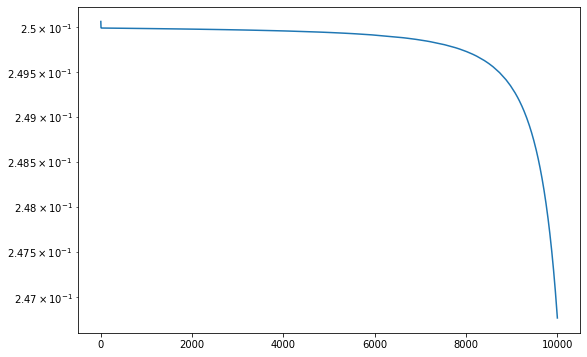

In [93]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [94]:
# Optimized weights and biases
print('Optimized Weights: ', optWeights)
print('Optimized Biases: ', optBiases)
# Forward feed with optimized weights
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed_cupy(inputs_cupy, nLayers, optWeights, optBiases, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)
# New Error
print('New Average Error with optimized weights:\n', MSE_loss_cupy(a[nLayers],outputs_cupy)/batchSize)
print('Input: ',inputs_cupy)
print('Output: ',a[nLayers])
print('Expected Output: ',outputs_cupy)

Optimized Weights:  [array([[-1.1623688 , -1.088947  ],
       [-0.15677601, -0.00178388],
       [-0.02966575,  0.05611883],
       [ 0.48794374, -0.1468346 ],
       [ 0.7532637 , -0.195145  ],
       [ 0.51789147, -0.31723636],
       [-0.72448313, -0.12385192],
       [ 0.5635177 , -0.25860852],
       [-1.1904597 , -1.3120279 ],
       [-0.10814718, -0.06519958]], dtype=float32), array([[ 0.52134067,  0.40279645, -0.3359638 ,  0.10200342, -0.28401288,
        -0.38269022, -0.10434584,  0.41219696,  0.7465167 , -0.41297895],
       [ 0.52722836, -0.00219814,  0.24640879, -0.40123922,  0.30495375,
        -0.12084039,  0.39051607,  0.2753815 ,  0.08960208, -0.21695593],
       [-0.5520586 , -0.3940264 , -0.23358555, -0.4233679 ,  0.22552772,
         0.03305994,  0.07575031, -0.4095192 , -0.2994039 , -0.48042983],
       [ 0.22051959,  0.04118045,  0.08567029,  0.26999137,  0.497969  ,
         0.07552187, -0.25171503,  0.23237324,  0.771549  ,  0.19546917],
       [ 0.4463281 , -0.

In [95]:
print('Difference b/w our weights & biases and keras results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(cp.asnumpy(optWeights[i])-model.layers[i].get_weights()[0].T).max())
    print(abs(cp.asnumpy(optBiases[i])-model.layers[i].get_weights()[1].T).max())

Difference b/w our weights & biases and keras results:

Layer :  1
0.91840273
0.35007784

Layer :  2
0.34562656
0.13442461

Layer :  3
0.27184945
0.15306604

Layer :  4
0.53991956
0.04125999


## ** NEW METHOD ** With opt_einsum expressions (It is faster than np.einsum but only slightly)

In [96]:
%%time
# Run optimization
optWeights, optBiases, errorPlot = nn_optimize_fast_cupy(inputs_cupy, outputs_cupy, activation_func_names, nLayers, nEpochs=nEpochs, batchSize=batchSize, eeta=eeta, weights=weightsOriginal_cupy, biases=biasesOriginal_cupy, errorFunc=MSE_loss_cupy, gradErrorFunc=MSE_loss_grad_cupy,miniterEpoch=100,batchProgressBar=False,miniterBatch=100)



  0%|          | 0/10000 [00:00<?, ?it/s]

Average Error with initial weights and biases: 0.25006646
Wall time: 22.5 s


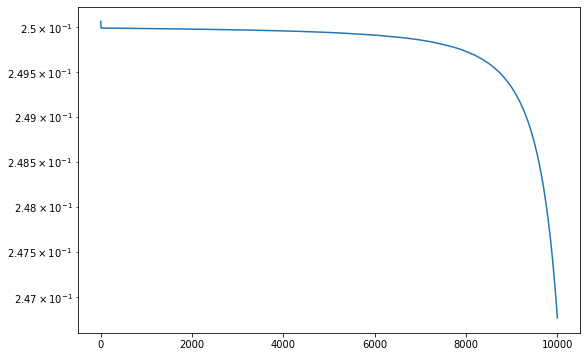

In [97]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [98]:
# Optimized weights and biases
print('Optimized Weights: ', optWeights)
print('Optimized Biases: ', optBiases)
# Forward feed with optimized weights
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed_cupy(inputs, nLayers, optWeights, optBiases, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)
# New Error
print('New Average Error with optimized weights:\n', MSE_loss_cupy(a[nLayers],outputs_cupy)/batchSize)
print('Input: ',inputs_cupy)
print('Output: ',a[nLayers])
print('Expected Output: ',outputs_cupy)

Optimized Weights:  [array([[-1.1623775 , -1.088958  ],
       [-0.1567756 , -0.00178348],
       [-0.02966591,  0.05611844],
       [ 0.48794505, -0.14683452],
       [ 0.7532642 , -0.19514512],
       [ 0.5178905 , -0.3172373 ],
       [-0.72448355, -0.12385251],
       [ 0.563519  , -0.2586083 ],
       [-1.1904719 , -1.3120397 ],
       [-0.10814696, -0.06519978]], dtype=float32), array([[ 0.5213455 ,  0.40279606, -0.33596477,  0.10200307, -0.28401297,
        -0.3826911 , -0.10434673,  0.4121963 ,  0.7465233 , -0.41297957],
       [ 0.5272304 , -0.0021985 ,  0.24640831, -0.40123942,  0.30495358,
        -0.12084081,  0.39051554,  0.27538127,  0.08960497, -0.21695662],
       [-0.5520601 , -0.3940255 , -0.23358466, -0.42336777,  0.22552767,
         0.03306036,  0.07575142, -0.40951884, -0.29940534, -0.48042896],
       [ 0.22052269,  0.04117893,  0.08566883,  0.26999065,  0.4979687 ,
         0.07552121, -0.2517168 ,  0.2323728 ,  0.77155286,  0.19546756],
       [ 0.4463288 , -0.

TypeError: Argument 'b' has incorrect type (expected cupy._core.core.ndarray, got numpy.ndarray)

In [ ]:
print('Difference b/w our weights & biases and keras results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(cp.asnumpy(optWeights[i])-model.layers[i].get_weights()[0].T).max())
    print(abs(cp.asnumpy(optBiases[i])-model.layers[i].get_weights()[1].T).max())

# PyTorch

In [ ]:
### Choose device: 'cuda' or 'cpu'
device = 'cpu'
# device = 'cuda'

## Generate the network programatically

## Method 1

In [ ]:
Layers = []
# Input layer
Layers.append(torch.nn.Linear(nInputs, neurons_per_layer[0]))
Layers.append(torch.nn.Sigmoid())

if nLayers>1:
    # Hidden layers
    for i in range(1,nLayers-1):
        Layers.append(torch.nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i]))
        Layers.append(torch.nn.Sigmoid())
    # Output layer
    Layers.append(torch.nn.Linear(neurons_per_layer[nLayers-2], neurons_per_layer[nLayers-1]))
    Layers.append(torch.nn.Sigmoid())

In [ ]:
Network = torch.nn.Sequential(*Layers)

In [ ]:
print(Network)

## Method 2 (Suitable for us to modify weights for each layer to be same as keras and my implementation)

In [ ]:
Network = torch.nn.Sequential()
 
# Input layer -> 1st hidden layer
Network.add_module(str(0),torch.nn.Linear(nInputs, neurons_per_layer[0]))
# Activation function after first hidden layer
Network.add_module('act0',act_func_dict_PyTorch[activation_func_names[0]])

if nLayers>1:
    # Hidden layers
    for i in range(1,nLayers-1):
        Network.add_module(str(i),torch.nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i]))
        Network.add_module('act'+str(i),act_func_dict_PyTorch[activation_func_names[i]])
        
    # Output layer
    Network.add_module(str(nLayers-1),torch.nn.Linear(neurons_per_layer[nLayers-2], neurons_per_layer[nLayers-1]))
    Network.add_module('act'+str(nLayers-1),act_func_dict_PyTorch[activation_func_names[nLayers-1]])

In [ ]:
# torch.nn.init.constant_(Network.weight, 2.0)
Network.to(device=device)

## initial weights and biases generated by Pytorch

In [ ]:
print(Network[0].weight)
print(Network[0].bias)

## Change them to be the same as others

## **IMPORTANT NOTE**: The returned tensor and the original array share the same memory. So any changes to the tensor change the array as well.

Reference: https://pytorch.org/docs/stable/generated/torch.from_numpy.html



In [ ]:
for i in range(nLayers):
    # Weights
#     Network._modules[str(i)].weight.data = torch.from_numpy(weightsOriginal[i]).to(dtype=torch.float32)
    Network._modules[str(i)].weight.data = torch.tensor(weightsOriginal[i]).to(dtype=torch.float32)
    # Biases
#     Network._modules[str(i)].bias.data = torch.from_numpy(biasesOriginal[i]).to(dtype=torch.float32) # Convert to float32
    Network._modules[str(i)].bias.data = torch.tensor(biasesOriginal[i]).to(dtype=torch.float32) # Convert to float32

In [ ]:
for i in range(nLayers):
    # Weights
    print('Weights:\n')
    print(Network._modules[str(i)].weight.data)
    # Biases
    print('Biases:\n')
    print(Network._modules[str(i)].bias.data)

In [ ]:
### Get information about model
totpars = 0
for par in Network.parameters():
    newpars = 1
    for num in par.shape:
        newpars *= num
    totpars += newpars
print(Network)
print('%i trainable parameters' % totpars)

### Initialize loss function and optimizer
# crit = torch.nn.BCELoss()
# opt = torch.optim.SGD(Network.parameters(), lr=0.2)

crit = torch.nn.MSELoss()
opt = torch.optim.SGD(Network.parameters(), lr=eeta)

In [ ]:
inputsTorch = torch.from_numpy(inputs)
inputsTorch = inputsTorch.to(dtype=torch.float32) # Convert to float32
labels = torch.from_numpy(outputs)
labels = labels.to(dtype=torch.float32) # Convert to float32

In [ ]:
print(inputsTorch)
print(labels)

In [ ]:
%%time
### Set model in training mode and create the epochs axis
Network.train()
epochs = range(1, nEpochs)
errorPlot = []
### Train the model
for e in tqdm(epochs,leave=True,miniters=100):
    tr_loss = 0.
    samples = 0
    
    opt.zero_grad() # zero gradient values
    inputsTorch = inputsTorch.to(device=device) # move input and label tensors to the device with the model
    labels = labels.to(device=device)
    outputsTorch = Network(inputsTorch) # compute model outputs
    loss = crit(outputsTorch, labels) # compute batch loss
    loss.backward() # back-propagate the gradients
    opt.step() # update the model weights
    tr_loss += loss.clone().cpu().item()*len(inputsTorch) # add the batch loss to the running loss
    samples += len(inputsTorch) # update the number of processed samples
    tr_loss /= samples # compute training loss
    errorPlot.append(tr_loss)
#     print(e, tr_loss)

In [ ]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [ ]:
print('Difference b/w our weights & biases and PyTorch results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(torch.tensor(cp.asnumpy(optWeights[i])).to(dtype=torch.float32)-Network._modules[str(i)].weight.data).max())
    print(abs(torch.tensor(cp.asnumpy(optBiases[i])).to(dtype=torch.float32)-Network._modules[str(i)].bias.data).max())

In [265]:
torch.get_num_threads()

8

In [60]:
# torch.set_num_threads(4)
torch.get_num_threads()

8

In [61]:
torch.get_num_threads()

8